# Finding the effective fare rate for taxi fares

The effective rate for taxi fares may have changed across time, even with our adjustments for taxi fare increases. Therefore, we will use an ensemble method for calculating taxi fares, by calculating the slope of $\text{fare amount v.s trip distance}$, and considering the base rate.

Thus, for each year $Y = \{2009, 2010, \dots \}$, and it's fitted slope $\beta_Y = \{\beta_{2009}, \beta_{2010}, \dots\}$, we apply some weighting of the years $Y$ and their rates to find an estimator for today's rate.

#### Why am I applying this ensemble method?

The data isn't still clean enough for us to find the fare rate using all of the data from 2009 across to 2023. By applying a year-by-year ensemble method, we still use all the data, and have a more accurate fit for these sample groups.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import statsmodels.api as sm
from sklearn.linear_model import QuantileRegressor
import numpy as np

In [46]:
year_data = defaultdict(list)

date_ptr = '2009-01'

while date_ptr != '2024-01':
    date_data = pd.read_parquet(f'../data/tr_data/{date_ptr}.parquet')
    date_year = pd.to_datetime(date_ptr).year
    year_data[date_year].append(date_data)
    date_ptr = (pd.to_datetime(date_ptr) + pd.DateOffset(months=1)).strftime('%Y-%m')

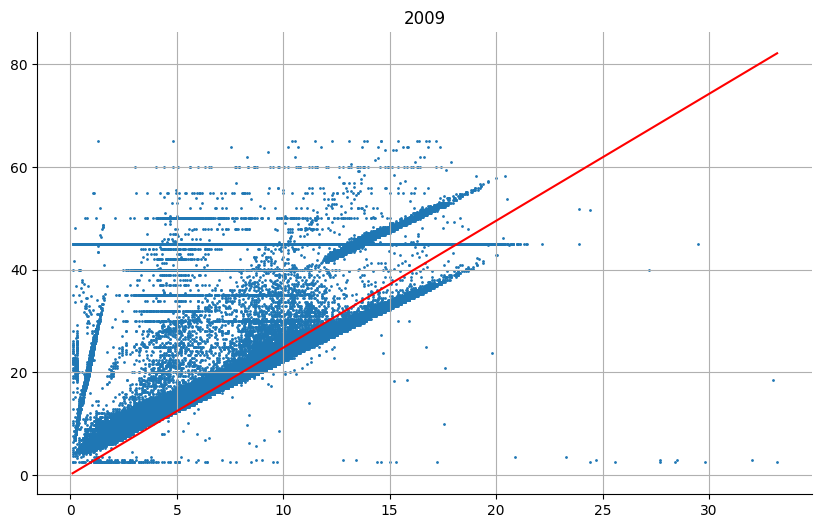

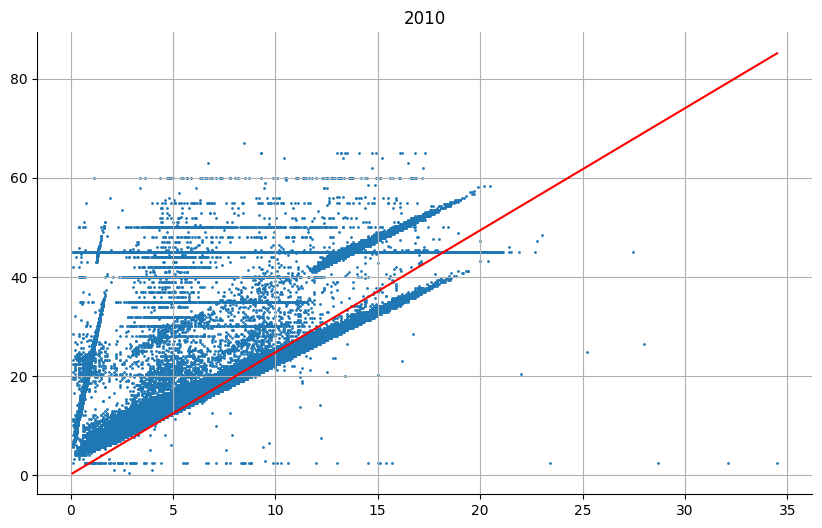

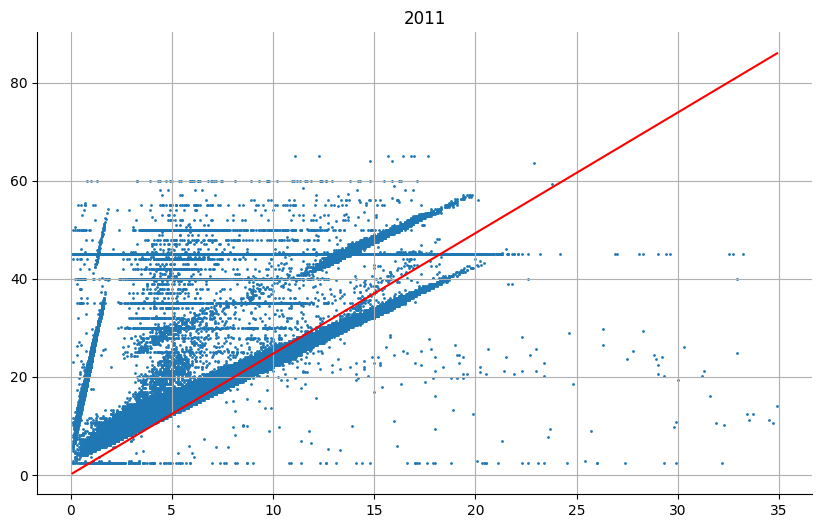

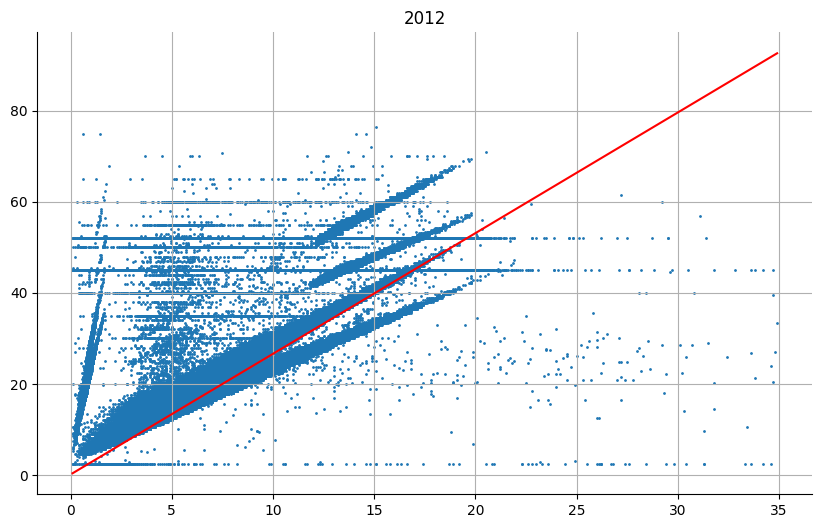

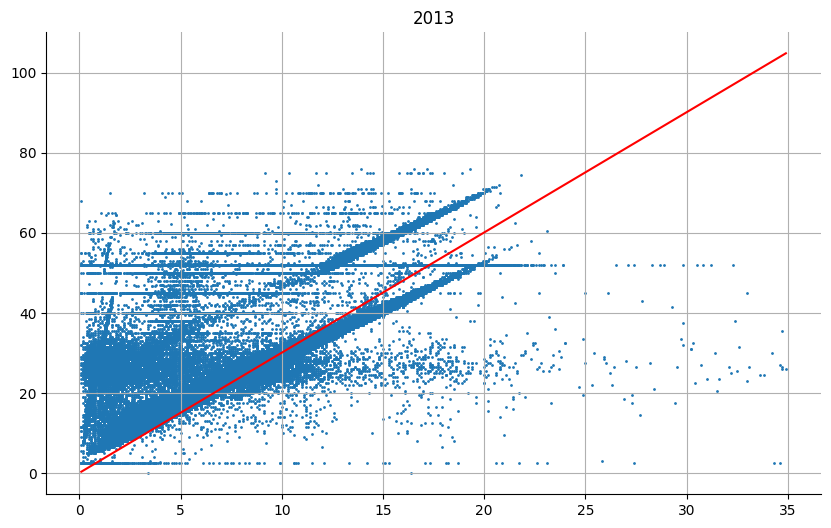

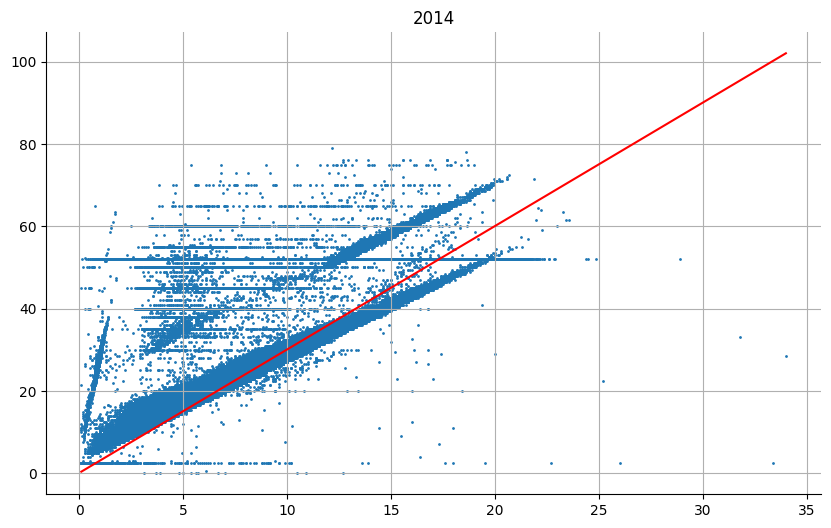

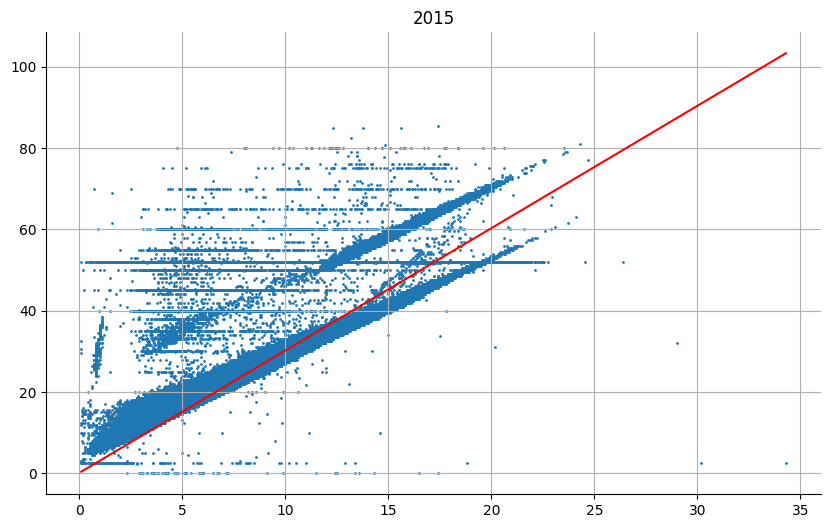

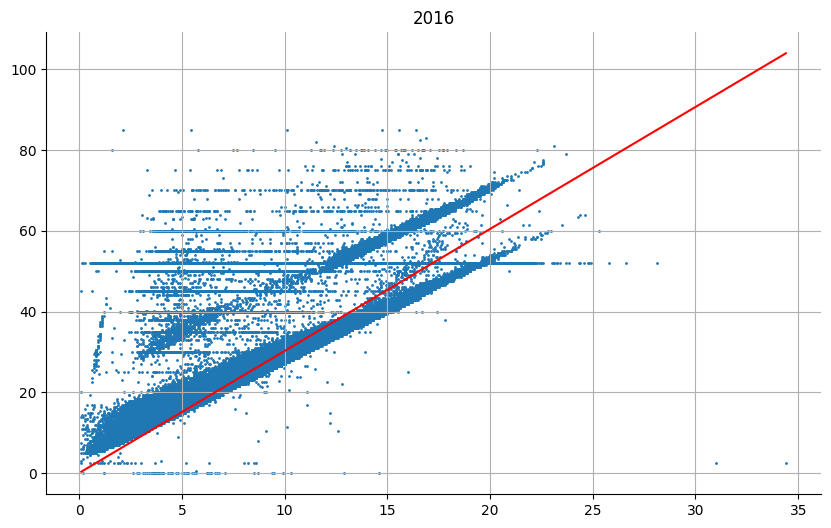

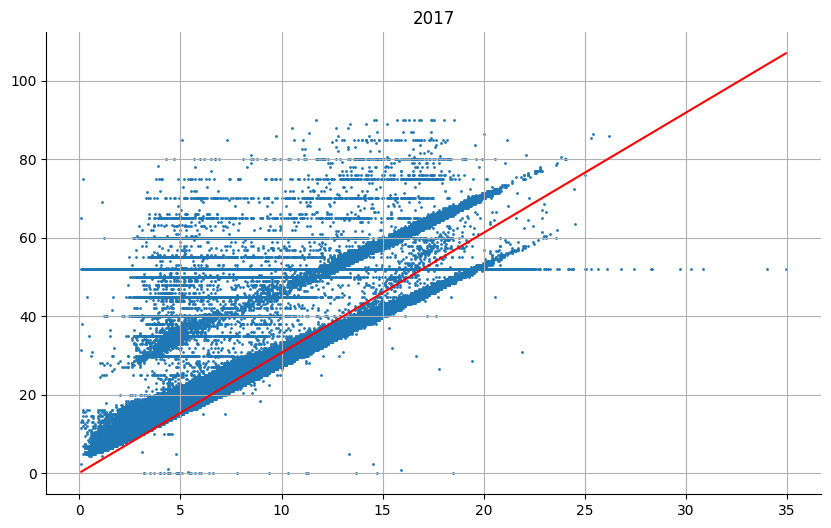

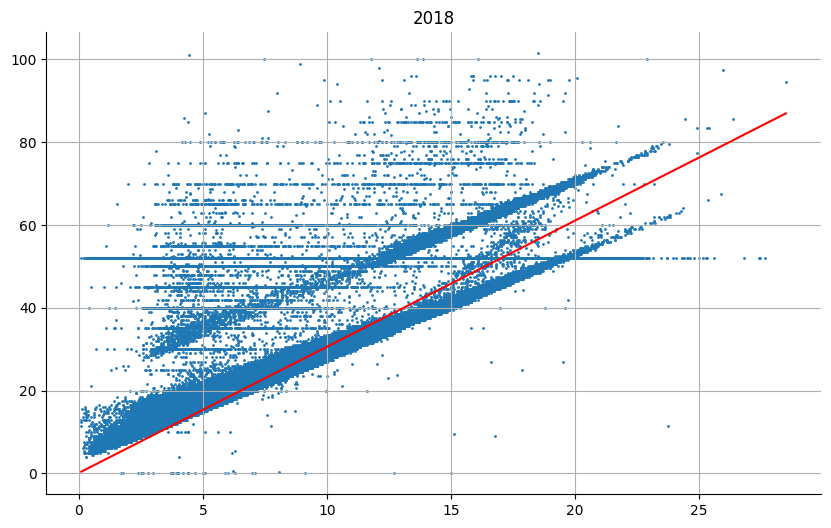

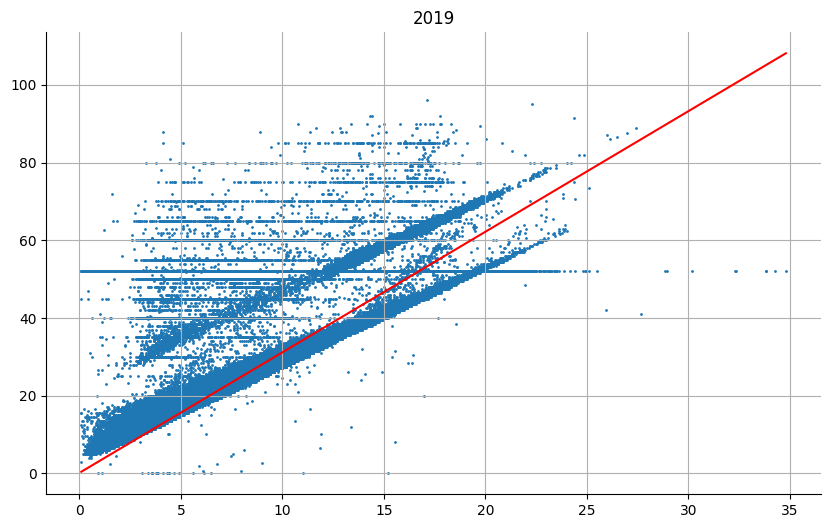

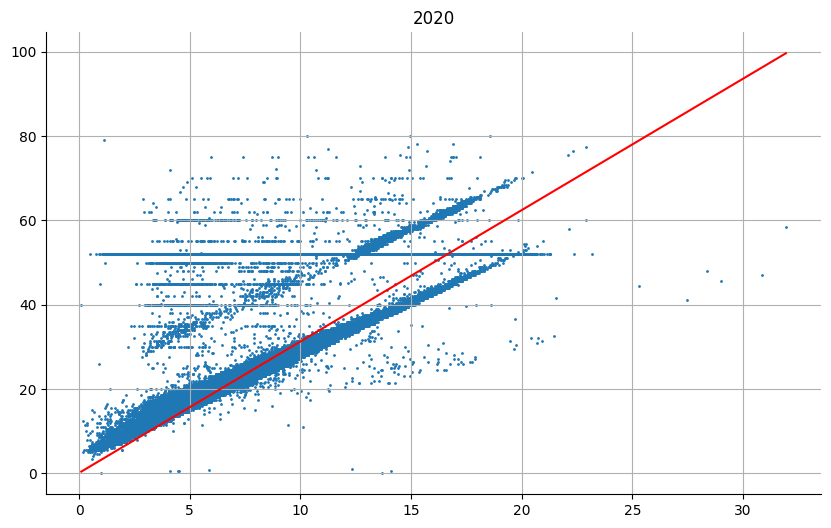

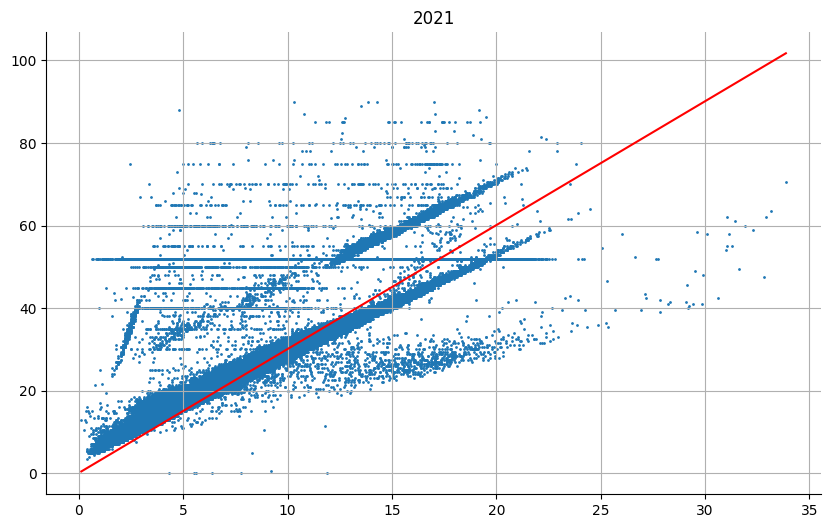

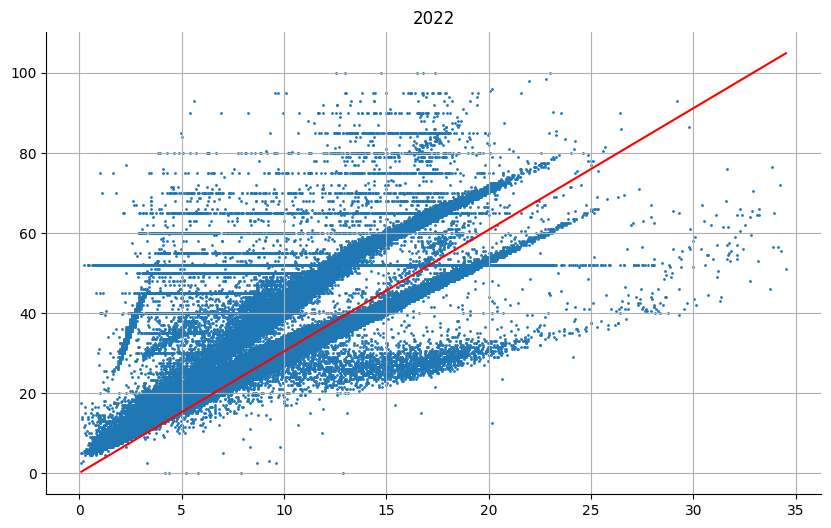

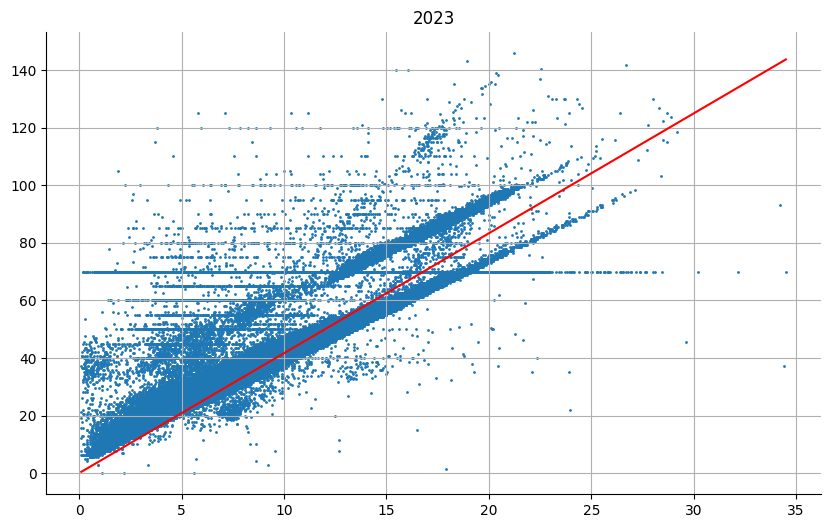

In [43]:
from sklearn.metrics import mean_absolute_error

for k, v in year_data.items():
    v_data = pd.concat(v)
    v_model = sm.OLS(sm.add_constant(v_data['fare_amount']), v_data['trip_distance']).fit()
    v_input = np.linspace(v_data['trip_distance'].min(), v_data['trip_distance'].max(), 500)
    v_params = v_model.params.values[0]
    v_output = v_input * v_params[1] + v_params[0]

    plt.figure(figsize=(10, 6))
    plt.scatter(v_data['trip_distance'], v_data['fare_amount'], s=1)
    plt.plot(v_input, v_output, color='red')
    sns.despine()
    plt.grid()
    plt.title(k)
    plt.show()

Our initial attempts to fit for the effective rate are not too successful. The other data beyond the effective rate is quite noisy, and thus affects our fit for that lower bound which can evidently be seen.

Thus we approach the problem by attempting to isolate the lower bound 'triangle', by taking the lower quantiles of data. If we make a new feature `fare/distance`, we will be given the lower bounds of the triangle (and the few outliers beneath it).

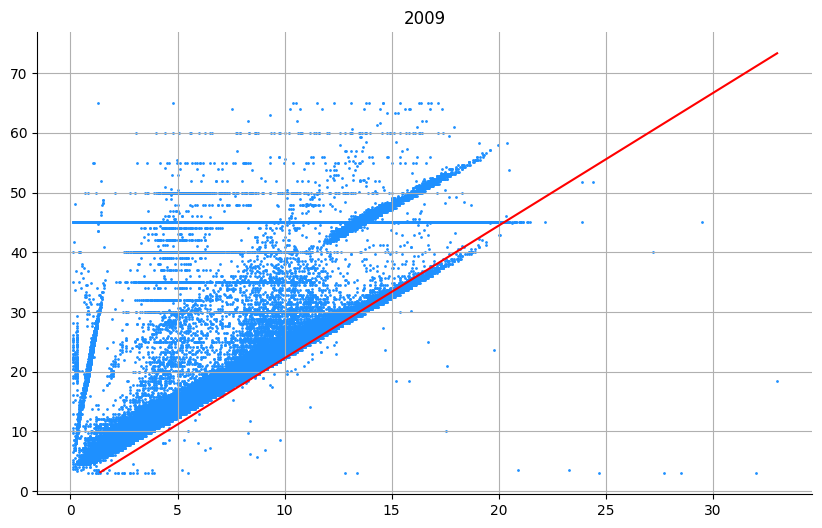

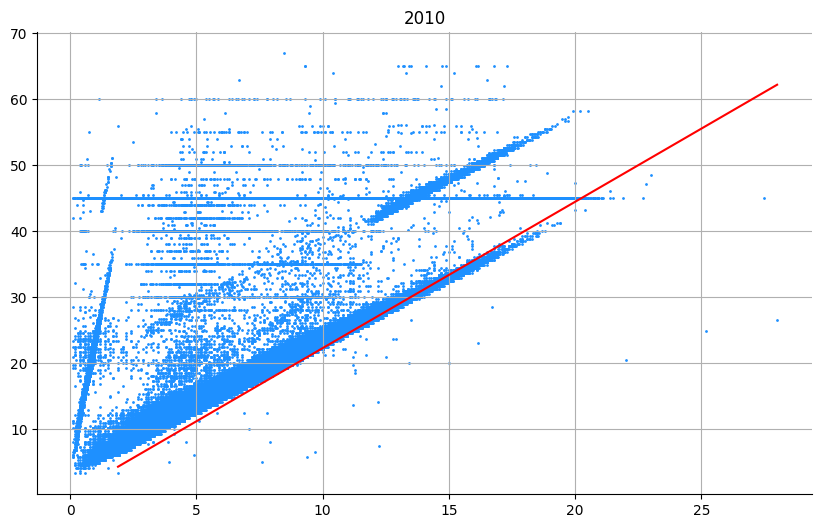

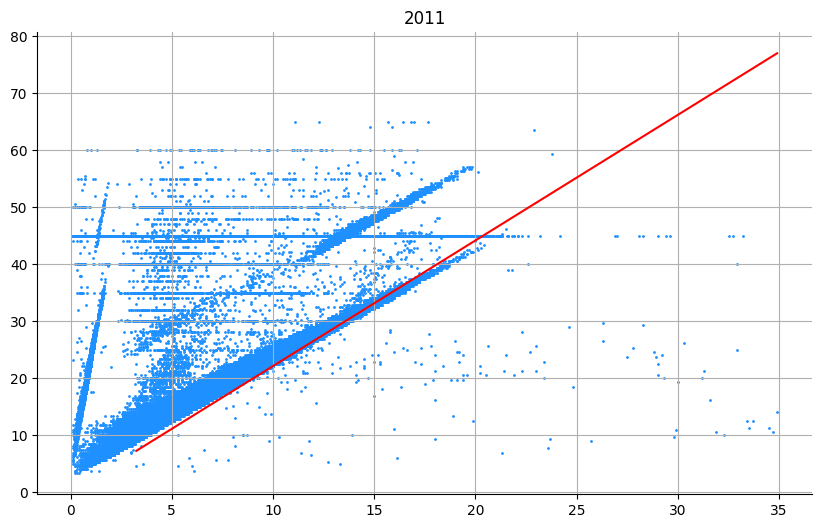

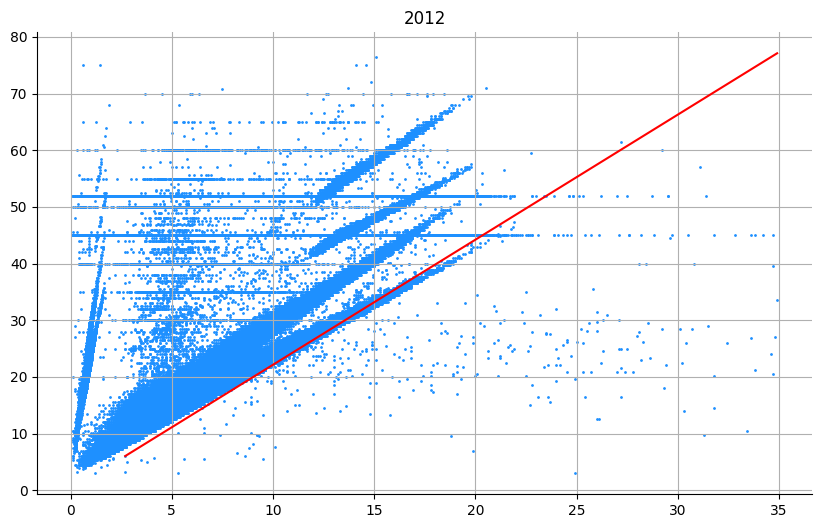

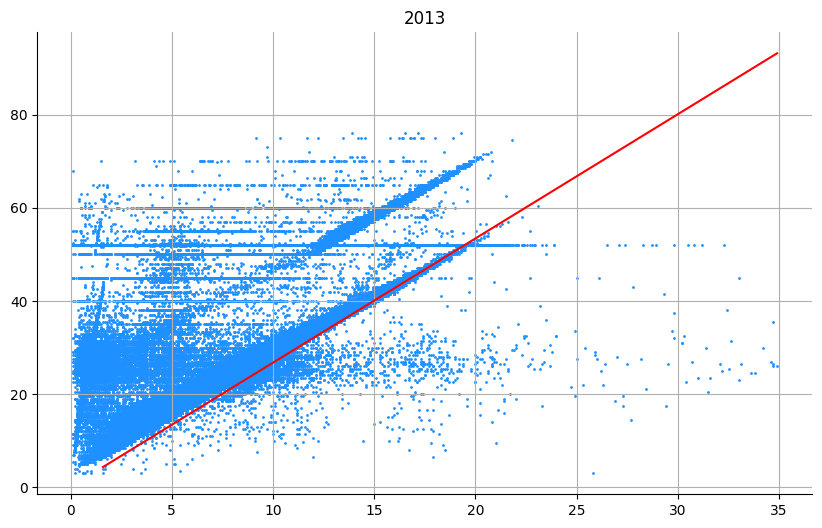

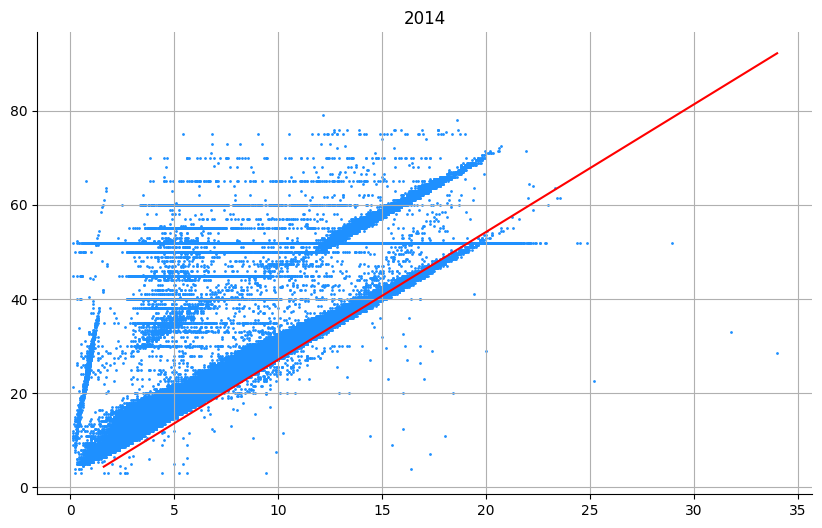

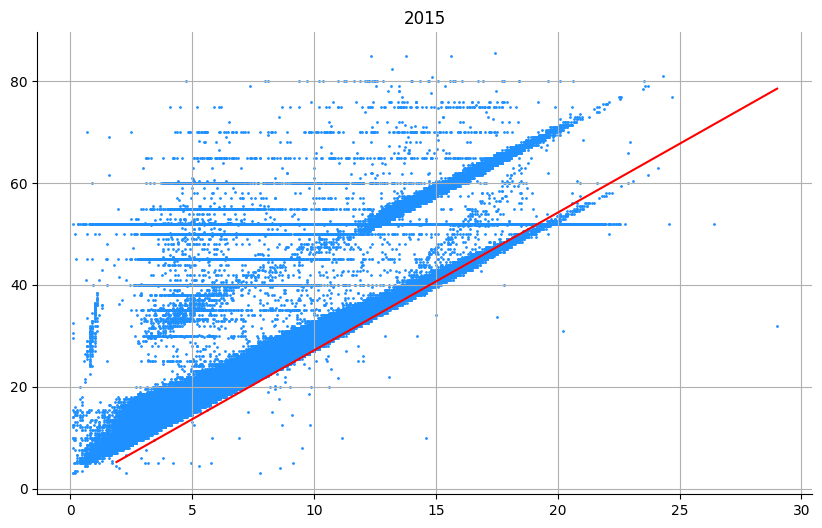

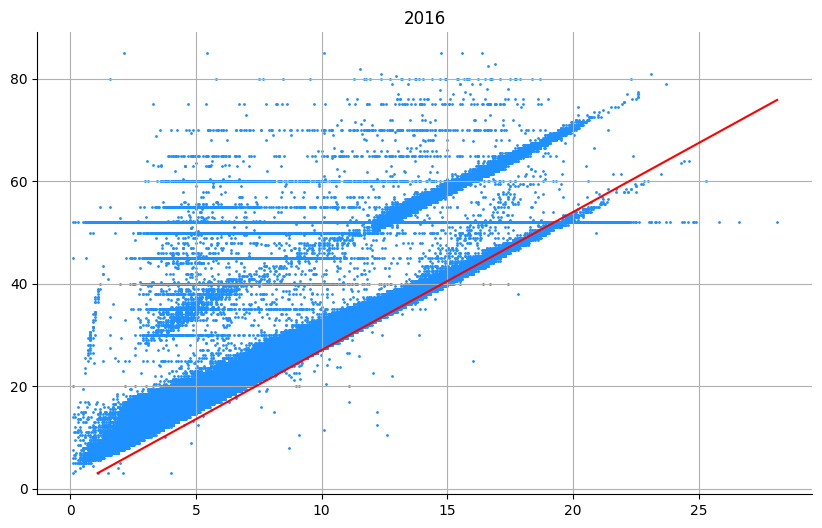

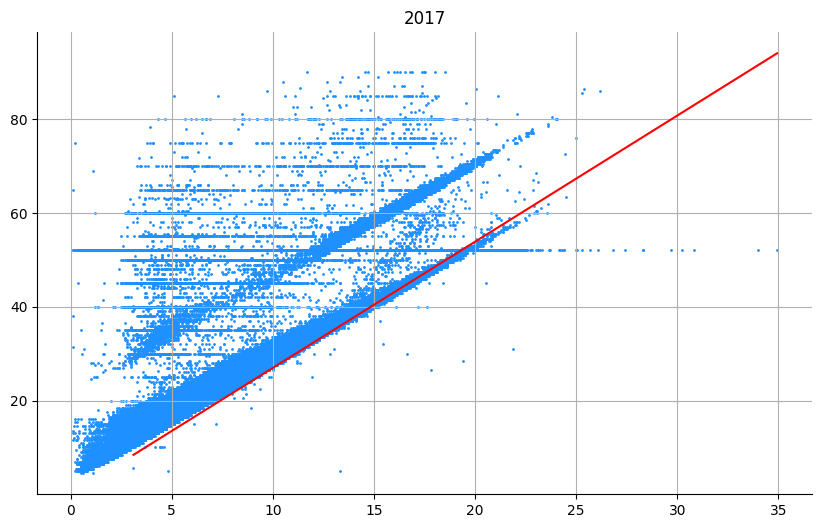

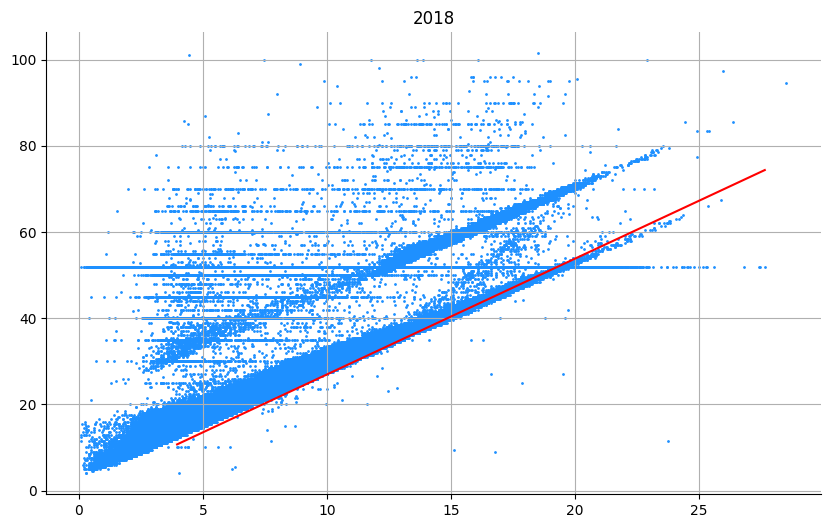

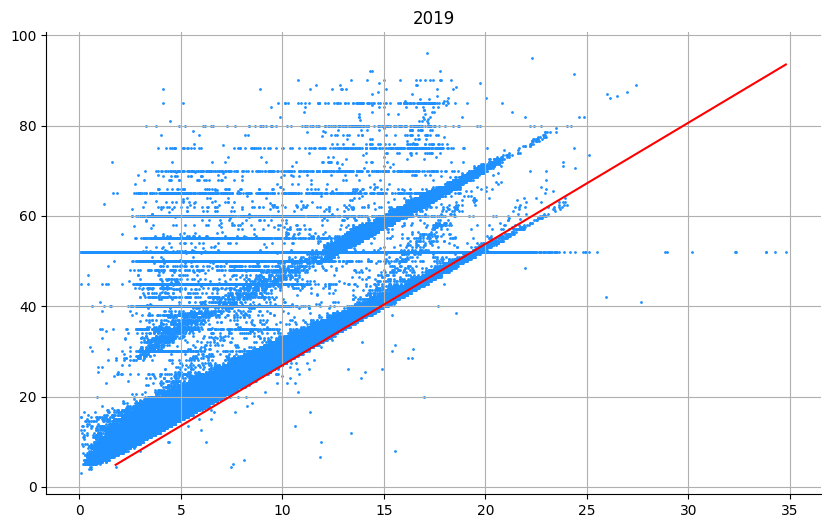

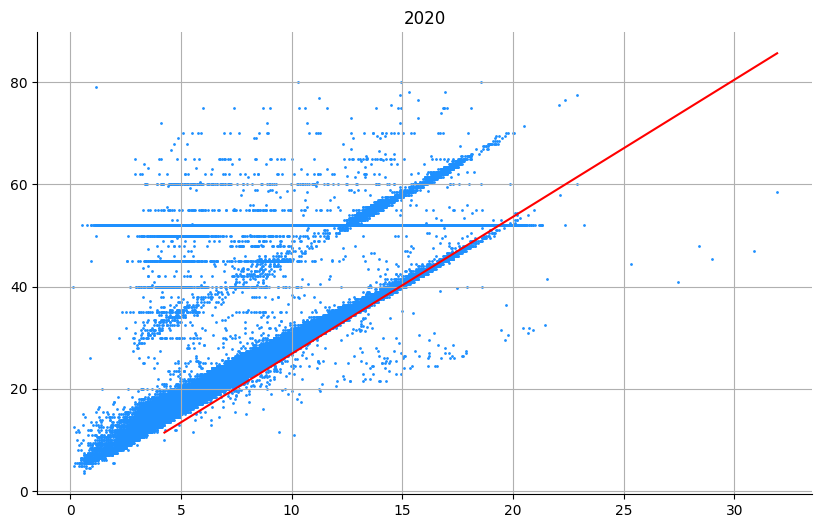

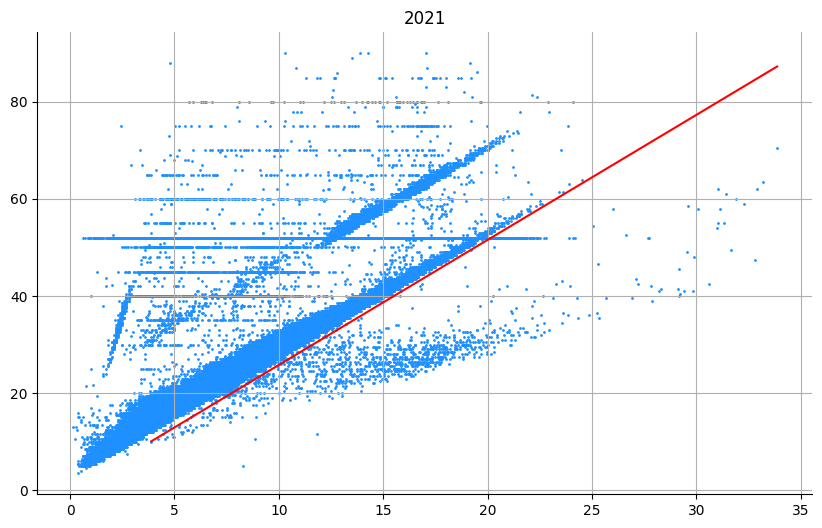

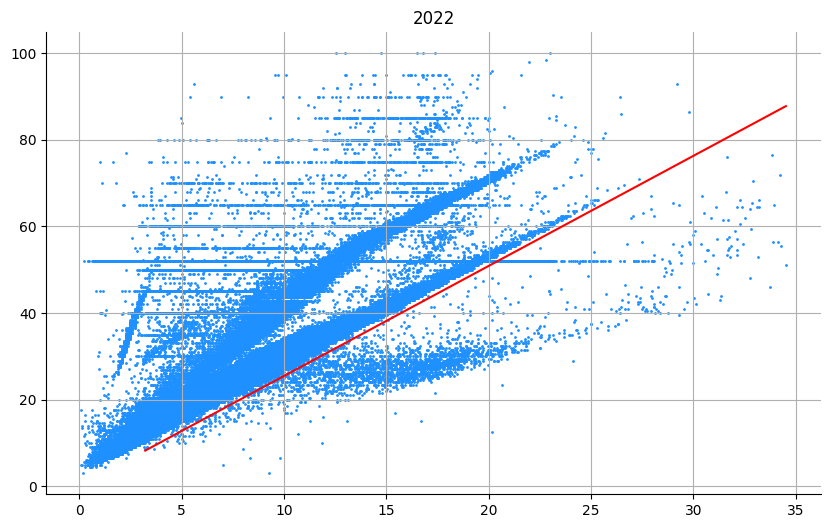

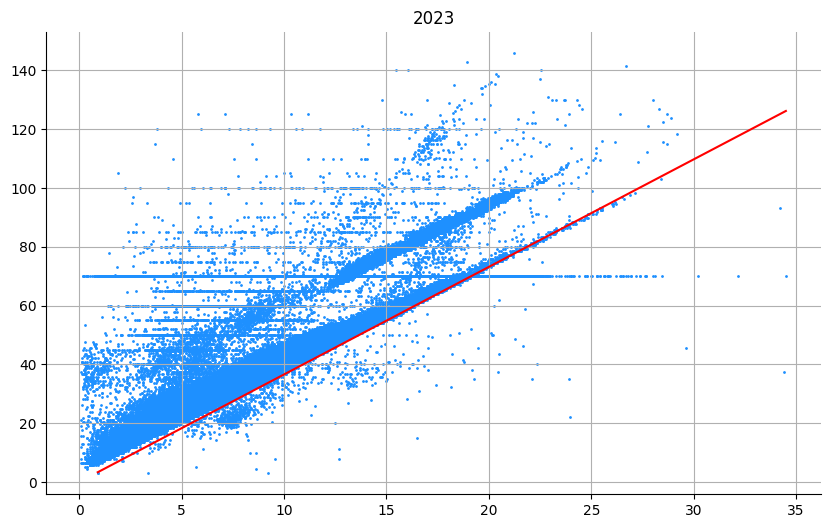

In [54]:
ensemble_data = []

for k, v in year_data.items():
    data = pd.concat(v)
    data['fare/distance'] = data['fare_amount'] / data['trip_distance']
    data = data[data['fare_amount'] >= 3] 
    # there were a few outliers which had constant taxi fares at ~3...
    # might be cab drivers who held a ride for someone, but they didn't
    # end up taking the cab? either way, bad data for us. 

    v_data = data[data['fare/distance'] < data['fare/distance'].quantile(0.03)]
    v_model = sm.OLS(sm.add_constant(v_data['fare_amount']), v_data['trip_distance']).fit()
    v_input = np.linspace(v_data['trip_distance'].min(), v_data['trip_distance'].max(), 500)
    v_params = v_model.params.values[0]
    v_output = v_input * v_params[1] + v_params[0]

    ensemble_data.append({
        'year': k,
        'effective_rate': v_params[1]
    })

    plt.figure(figsize=(10, 6))
    plt.scatter(data['trip_distance'], data['fare_amount'], s=1, color='dodgerblue')
    plt.plot(v_input, v_output, color='red')
    sns.despine()
    plt.grid()
    plt.title(k)
    plt.show()

We are now much more closer to that effective rate. Consider the below data for the effective rate across years.

Text(0.5, 1.0, 'Taxi fare rate per mile across history')

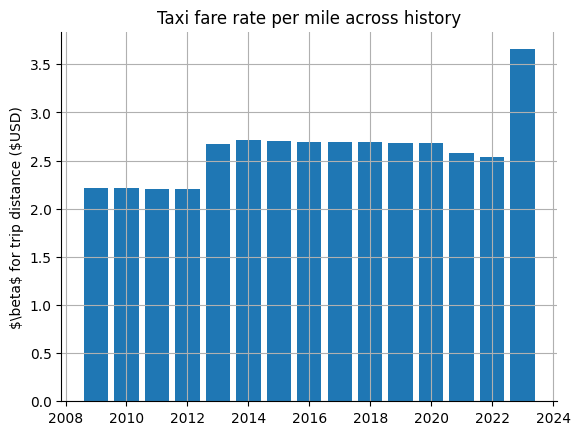

In [64]:
ensemble_df = pd.DataFrame(ensemble_data)

plt.bar(ensemble_df['year'], ensemble_df['effective_rate'])
sns.despine()
plt.ylabel('$\\beta$ for trip distance ($USD)')
plt.grid()
plt.title('Taxi fare rate per mile across history')

We apply an **exponentially weighted average**, as the recency of the data is important to the *accuracy* of today's true rate.

In [87]:
ewa = ensemble_df['effective_rate'].ewm(span=3, adjust=False).mean()

Text(0.5, 1.0, 'Exponentially weighted fare rates')

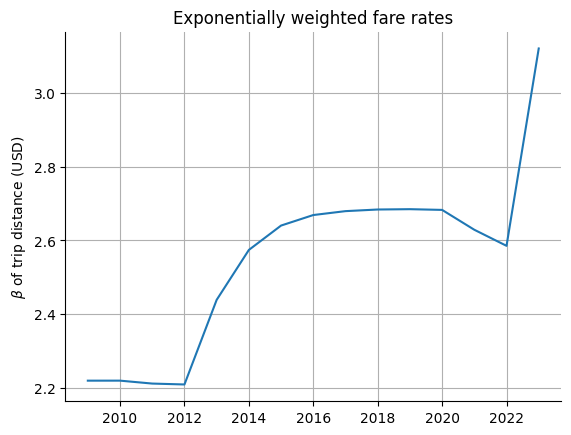

In [88]:
plt.plot(ensemble_df['year'], ewa)
sns.despine()
plt.ylabel('$\\beta$ of trip distance (USD)')
plt.grid()
plt.title('Exponentially weighted fare rates')